##### Packages

In [34]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import re
import emoji

## Data Processing

##### Loading and Inspecting

In [41]:
data = pd.read_csv("C:/Users/vebky\FIE458/termpaper/Cleaned_Data.csv").dropna(subset=['Text'])

# Sampling
sample_fraction = 0.1
data = data.sample(frac=sample_fraction, random_state=1)
data.head()

,Unnamed: 0,Project,Text,Scam,Text_Encoded_Word,Text_Encoded_Character
231948,231948,gnosis,another hidden gem the # chain. the #giveconom...,0,"[525773, 240202, 827312, 3780, 845896, 1110887...","[292, 218, 151, 243, 42, 86, 274, 0, 42, 260, ..."
82983,82983,oyster pearl,have you picked the #prismaticpearl multistick...,1,"[453004, 376150, 931201, 3780, 1010093, 422765...","[42, 292, 21, 86, 0, 57, 151, 173, 0, 266, 260..."
203685,203685,enjin coin,explained spectrocoin blog crypto crypto news...,0,"[932886, 734371, 378366, 924746, 924746, 57098...","[0, 86, 203, 266, 244, 292, 260, 218, 86, 277,..."
311703,311703,quant,@newsqnt @gverdian it’s inevitable that are he...,0,"[876382, 1167917, 320018, 1032666, 877416, 175...","[107, 218, 86, 208, 62, 70, 218, 243, 0, 107, ..."
149422,149422,celo,"criptomonedas perdedoras: $xym symbol -11,05% ...",0,"[497368, 437153, 1148255, 118178, 1286925, 550...","[153, 274, 260, 266, 243, 151, 124, 151, 218, ..."


In [42]:
data.shape

(40809, 6)

In [43]:
# Preprocessing text
text = data['Text'].values
text[:5]

array(["another hidden gem the # chain. the #giveconomy here! excited part the future giving with $giv &amp; @givethio #blockchain4good #defi4good #givethlove #givdrop https://t.co/zx9awxmyuy @sweettr33994 @scaraarchive they are gods, they have  and can use them, cant know scaramouche could use @petitenicoco that woman actual doctor, huh? guys, i'm going start dipping into the vatican archives how become exorcist. i'm realizing now the catholics obviously had that thing for reason.",
       'have you picked the #prismaticpearl multisticks from @bitebeauty? what the h*ck are you waiting for? let give you reasons why you need add  your collection: #cleanbeauty #foodgrade #makeuplover #bitebeauty #oysterpearl https://t.co/eqrvwajmso @robb0226 rob,the snapshot was done last april 13th and distribution oyster shell (shl) all  (prl) users kucoin will the following weeks. just wait for further announcement. thank you @greenwood_troy @richy_clare @btc @eth @zeepinchain @gala @kcs troy, apologi

##### Formatting

In [44]:
# font to lowercase
text = [x.lower() for x in text]

# removing URLs from vocabulary
text = [re.sub(r'http\S+', '{URL}', x) for x in text]

# removing @mentions from vocabulary
text = [re.sub(r'@\S+', '', x) for x in text]

# filter out numbers
text = [re.sub(r'[0-9]+', '', x) for x in text]

# converting emojis to text
text = [emoji.demojize(x) for x in text]

In [45]:
# inspecting text after preprocessing
text[:5]

["another hidden gem the # chain. the #giveconomy here! excited part the future giving with $giv &amp;  #blockchaingood #defigood #givethlove #givdrop {URL}   they are gods, they have  and can use them, cant know scaramouche could use  that woman actual doctor, huh? guys, i'm going start dipping into the vatican archives how become exorcist. i'm realizing now the catholics obviously had that thing for reason.",
 'have you picked the #prismaticpearl multisticks from  what the h*ck are you waiting for? let give you reasons why you need add  your collection: #cleanbeauty #foodgrade #makeuplover #bitebeauty #oysterpearl {URL}  rob,the snapshot was done last april th and distribution oyster shell (shl) all  (prl) users kucoin will the following weeks. just wait for further announcement. thank you        troy, apologize. the snapshot was done last april th and distribution oyster shell (shl) all  (prl) users kucoin will the following weeks.',
 ' explained spectrocoin blog crypto crypto news 

In [46]:
# Creating vocabulary
vectorizer = CountVectorizer(max_features = 1000, stop_words='english')
X = vectorizer.fit_transform(text)

In [47]:
# see words in vocabulary
vocabulary = vectorizer.vocabulary_
vocabulary.items()

dict_items([('chain', 132), ('excited', 277), ('future', 326), ('giving', 342), ('amp', 30), ('url', 911), ('use', 915), ('know', 451), ('guys', 368), ('going', 348), ('start', 812), ('thing', 861), ('reason', 695), ('waiting', 939), ('let', 472), ('need', 571), ('add', 11), ('collection', 160), ('th', 856), ('users', 918), ('following', 308), ('weeks', 958), ('just', 444), ('wait', 938), ('thank', 857), ('blog', 90), ('crypto', 190), ('news', 578), ('week', 957), ('social', 792), ('activity', 8), ('galaxy', 331), ('score', 746), ('trade_mark', 882), ('altrank', 27), ('mentions', 539), ('engagements', 255), ('contributors', 175), ('dominance', 236), ('shared', 766), ('links', 484), ('enj', 256), ('lunarshare', 517), ('people', 624), ('think', 863), ('better', 74), ('work', 972), ('world', 975), ('needs', 573), ('qnt', 679), ('network', 576), ('great', 356), ('year', 987), ('cap', 122), ('buy', 116), ('check', 141), ('data', 204), ('long', 497), ('term', 850), ('short', 774), ('profit',

##### Training and Validation Sets

In [48]:
# designating classifications
y = data['Scam'].values

# creating randomly selected balanced training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [56]:
# dimensions of training and validation sets
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(32647, 1000)
(8162, 1000)
(32647,)
(8162,)


In [49]:
# Convert the sparse matrices to dense arrays
X_train_dense = X_train.toarray()
X_val_dense = X_val.toarray()

# Reshape the input data to have an additional dimension (channels)
X_train_reshaped = np.expand_dims(X_train_dense, axis=-1)
X_val_reshaped = np.expand_dims(X_val_dense, axis=-1)

## CNN Model

##### Model Architecture

In [50]:
vocab_size = len(vectorizer.vocabulary_)

# Calculate the length of each sequence
sequence_lengths = np.sum(X.toarray() != 0, axis=1)

# Set max_length to the 90th percentile
max_length = int(np.percentile(sequence_lengths, 90))

In [51]:
# Layers for the model
model = tf.keras.Sequential([
    layers.Conv1D(64, 5, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    layers.MaxPooling1D(pool_size=4),
    layers.Conv1D(32, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

##### Performance and Metrics

In [52]:
# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=10, validation_data=(X_val_reshaped, y_val), batch_size=32)

Epoch 1/10
1021/1021 [==============================] - 40s 39ms/step - loss: 0.5065 - accuracy: 0.7826 - val_loss: 0.5033 - val_accuracy: 0.7836
Epoch 2/10
1021/1021 [==============================] - 48s 47ms/step - loss: 0.4853 - accuracy: 0.7943 - val_loss: 0.4738 - val_accuracy: 0.7959
Epoch 3/10
1021/1021 [==============================] - 47s 46ms/step - loss: 0.4745 - accuracy: 0.7978 - val_loss: 0.4641 - val_accuracy: 0.7978
Epoch 4/10
1021/1021 [==============================] - 43s 42ms/step - loss: 0.4601 - accuracy: 0.8022 - val_loss: 0.4626 - val_accuracy: 0.7978
Epoch 5/10
1021/1021 [==============================] - 52s 51ms/step - loss: 0.4502 - accuracy: 0.8068 - val_loss: 0.4463 - val_accuracy: 0.8070
Epoch 6/10
1021/1021 [==============================] - 76s 74ms/step - loss: 0.4480 - accuracy: 0.8088 - val_loss: 0.4541 - val_accuracy: 0.8041
Epoch 7/10
1021/1021 [==============================] - 38s 37ms/step - loss: 0.4413 - accuracy: 0.8116 - val_loss: 0.4507 -

In [53]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val_reshaped, y_val)
print(f"Validation loss: {loss}, accuracy: {accuracy}")

256/256 [==============================] - 1s 5ms/step - loss: 0.4347 - accuracy: 0.8156
Validation loss: 0.4347321093082428, accuracy: 0.8156089186668396


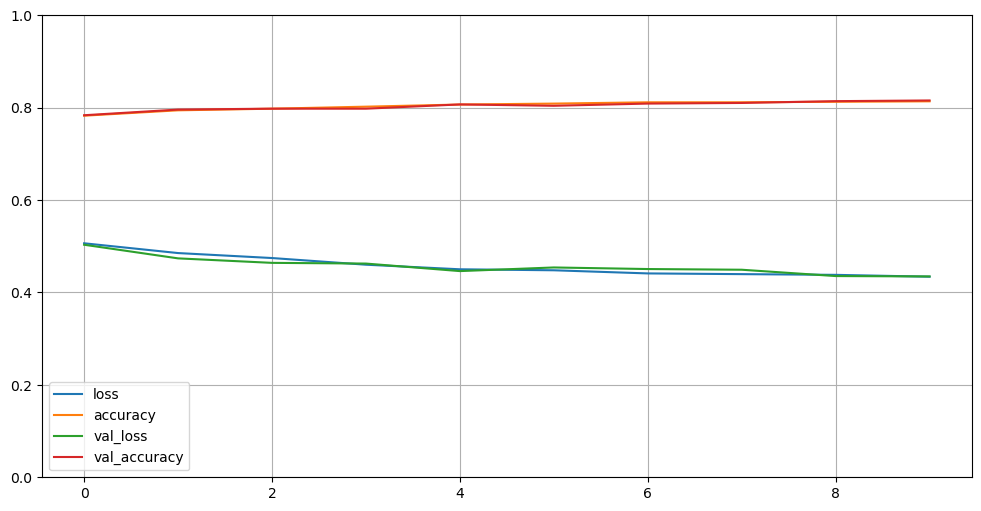

In [54]:
# Plot the accuracy and loss curves
pd.DataFrame(history.history).plot(figsize=(12, 6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## LOG

###### BOWCNN1: Validation loss: 0.4347321093082428, accuracy: 0.8156089186668396


In [ ]:
## BOWCNN 1
# Layers for the model
model = tf.keras.Sequential([
    layers.Conv1D(64, 5, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    layers.MaxPooling1D(pool_size=4),
    layers.Conv1D(32, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

###### BOWCNN2: